# WISE derived soil properties on a 30 by 30 arc-seconds global grid

**Overview**: https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/dc7b283a-8f19-45e1-aaed-e9bd515119bc

**Data files**: https://files.isric.org/public/wise/wise_30sec_v1.zip

---- NOTES ----

The soil database initially undergoes a general cleaning step (see function correction)

- pH is converted to original concentrations before processing and reverted afterwards

categorical columns e.g. DrainNum are processed as 
- group by class/category
- add proportion of components with similar class to calculate new proportion Value
- get index of max proportion and assign as final class for mapping unit

In [2]:
import os
import pandas as pd
import numpy as np
import rasterio as rio

### function to create soil raster from mapping unit and soil prop table

In [4]:
def write_prop_raster(data_path, smu_raster, soil_df, prop_col, prop_raster):
  
    # read smu_raster
    with rio.open(os.path.join(data_path, smu_raster)) as src:
      smu_raster = src.read().squeeze()
      metadata = src.meta
      
    # convert raster to df
    smu_df = pd.DataFrame(smu_raster.flatten(), columns=['IDSMU'])
    
    # join to tabular data
    merged_df = pd.merge(smu_df, soil_df, on='IDSMU', how='left')
    
    # reconstruct raster
    soil_prop_raster = merged_df[[prop_col]].to_numpy().reshape(metadata['height'], metadata['width'])
    
    # update metadata with soil property dtype
    prop_dtype = soil_df[prop_col].dtype
  
    if prop_dtype == float:
      metadata['dtype'] = 'float32' #rasterio does not support float16
      metadata['nodata'] = np.nan
    else:
      metadata['dtype'] = 'int8' #handles drainage class (valid range 1-7)
      metadata['nodata'] = 0
      
    # set nodata values and compression
    metadata['compress'] = 'LZW'
    
    # assign metadata and write file
    with rio.open(prop_raster, 'w', **metadata) as dst:
      dst.write(soil_prop_raster, 1)

## function to prepare soil property

In [20]:
def corrections(soil_df, prop):

    #################### GENERAL CORRECTIONS#########################
    # skip layers deeper than 1 meter (do for all)
    soil_df = soil_df[soil_df["BotDep"] <= 100]
    # skip records TAWC with -1, -2, -3, -4, -5, -7, -9
    soil_df = soil_df[soil_df["TAWC"] >= 0]
    # skip records with suid 0, 6997, 6998 (do for all)
    soil_df = soil_df[~soil_df["IDSMU"].isin([0, 6997, 6998])]

    if prop == 'TAWC':
      # TAWC corrected for coarse fragments > 2mm
      soil_df[prop] = (1-(soil_df["CFRAG"]/100))* soil_df[prop]

    if  'DrainNum' or 'Drain' in soil_df.columns:
      # skip records with drainage class -9
      soil_df = soil_df[~soil_df["DrainNum"].isin([-9])]
    ##################################################################

    return soil_df



def get_soil_property(data_path, data_file, prop='TAWC', prop_type='continuous'):

    # read textfile
    soil_df = pd.read_csv(os.path.join(data_path, data_file), sep=',', header=0)
    soil_df["IDSMU"] = soil_df["NEWSUID"].str[3:].astype(int)
    soil_df = soil_df.rename(columns={"SCID" : "IDSTU"})

    # check if property in dataframe
    assert prop in soil_df.columns, 'soil property not found'
    print('processing soil property {} of type {}'.format(prop, prop_type))

    # apply corrections
    soil_df = corrections(soil_df, prop)

    # PROCESSING
    soil_df = soil_df[["IDSMU", "IDSTU", "PROP", "TopDep", "BotDep"] + [prop]]

    # PH - convert to original concentrations
    if prop == 'PHAQ':
       soil_df[prop] = 10**(-soil_df[prop])
       
    # AGGREGATE BY PROPERTY DATA TYPE
    if prop_type == 'categorical':
       soil_df = soil_df.groupby(["IDSMU", "IDSTU", "PROP", prop]).agg(ROOTING_DEPTH=("BotDep", "max")).reset_index()

      # ignore ROOTING_DEPTH < 30
       soil_df = soil_df[soil_df["ROOTING_DEPTH"] >= 30]
       soil_df = soil_df.groupby(["IDSMU", prop]).agg(COMBINED_PROP=("PROP", "sum")).reset_index()

      # index of rows with maximum PROP value within each group
       max_prop_index = soil_df.groupby('IDSMU')['COMBINED_PROP'].idxmax()
       soil_df = soil_df.loc[max_prop_index, ['IDSMU', prop]]     

    else:
        soil_df["DEP_DIFF"] = soil_df["BotDep"] - soil_df["TopDep"]
        soil_df["_NUM"] = soil_df[prop] * soil_df["DEP_DIFF"]

        soil_df = soil_df.groupby(["IDSMU", "IDSTU", "PROP"]).agg(ROOTING_DEPTH=("BotDep", "max"),
                                                                  _NUM=("_NUM", "sum"),
                                                                  _DENOM=("DEP_DIFF", "sum")).reset_index()
        soil_df[prop] = soil_df["_NUM"] / soil_df["_DENOM"]

        # ignore ROOTING_DEPTH < 30
        soil_df = soil_df[soil_df["ROOTING_DEPTH"] >= 30]

        # aggregate to IDSMU
        soil_df["VAR_x_PROP"] = soil_df[prop] * soil_df["PROP"]
        soil_df = soil_df.groupby(["IDSMU"]).agg(_NUM=("VAR_x_PROP", "sum"),
                                                _DENOM=("PROP", "sum")).reset_index()
        soil_df[prop] = soil_df["_NUM"] / soil_df["_DENOM"]

        # PH - revert to log scale
        if prop == 'PHAQ':
           soil_df[prop] = -np.log10(soil_df[prop])

    return soil_df[["IDSMU", prop]]

## export soil properties as tiff

In [21]:
data_path = "/app/dev/AgML/soil/WISE30sec/Interchangeable_format"
data_file = "HW30s_FULL.txt"

# prepare soil property
soil_prop_awc = get_soil_property(data_path, data_file, prop='TAWC', prop_type='continuous')
soil_prop_drainage = get_soil_property(data_path, data_file, prop='DrainNum', prop_type='categorical')
soil_prop_ph = get_soil_property(data_path, data_file, prop='PHAQ', prop_type='continuous')

# write tif
write_prop_raster(data_path, 'wise_30sec_v1.tif', soil_prop_awc, "TAWC", '/app/dev/AgML/soil/soil_awc.tif')
write_prop_raster(data_path, 'wise_30sec_v1.tif', soil_prop_drainage, "DrainNum", '/app/dev/AgML/soil/soil_drainage.tif')
write_prop_raster(data_path, 'wise_30sec_v1.tif', soil_prop_ph, "PHAQ", '/app/dev/AgML/soil/soil_ph.tif')

## plot soil properties

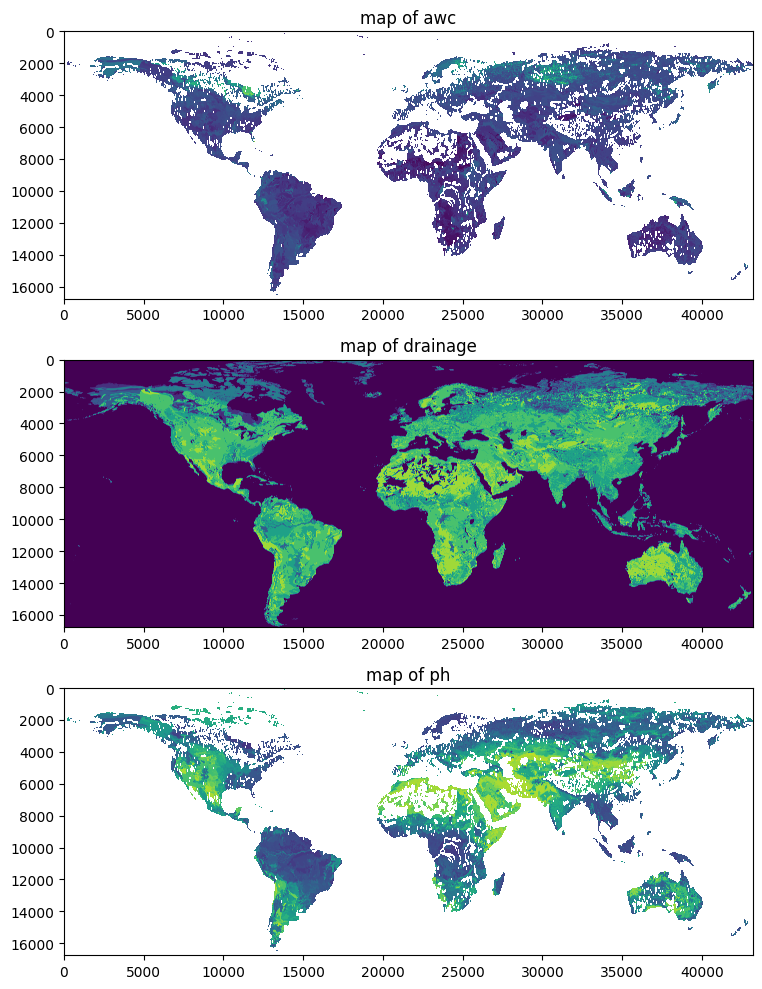

In [22]:
from matplotlib import pyplot as plt

# read awc raster
with rio.open('/app/dev/AgML/soil/soil_awc.tif') as src:
    awc_raster = src.read().squeeze()

# read drainage raster
with rio.open('/app/dev/AgML/soil/soil_drainage.tif') as src:
    drainage_raster = src.read().squeeze()

# read ph raster
with rio.open('/app/dev/AgML/soil/soil_ph.tif') as src:
    ph_raster = src.read().squeeze()


# Create a figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# Plot data on each subplot
axs[0].imshow(awc_raster)
axs[0].set_title('map of awc')

axs[1].imshow(drainage_raster)
axs[1].set_title('map of drainage')

axs[2].imshow(ph_raster)
axs[2].set_title('map of ph')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()